# Exercise VII: Decision Trees and Random Forests

Decision trees are as easy to implement with `sklearn` as any other of the models we've studied so far. As a quick example we could try to classify the iris dataset which we're already familiar with:

```{margin}
Example taken from [`sklearn`'s "Decision Trees" docs](https://scikit-learn.org/stable/modules/tree.html#classification).
```

In [14]:
import warnings
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
warnings.filterwarnings("ignore")

data = load_iris(as_frame=True)

X, y = data.data, data.target
y = y.replace({index: name for index, name in enumerate(data["target_names"])})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
decision_tree = DecisionTreeClassifier(random_state=42)
_ = decision_tree.fit(X_train, y_train)

Trees are even easy to visualize, thanks to the [`plot_tree()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) function:

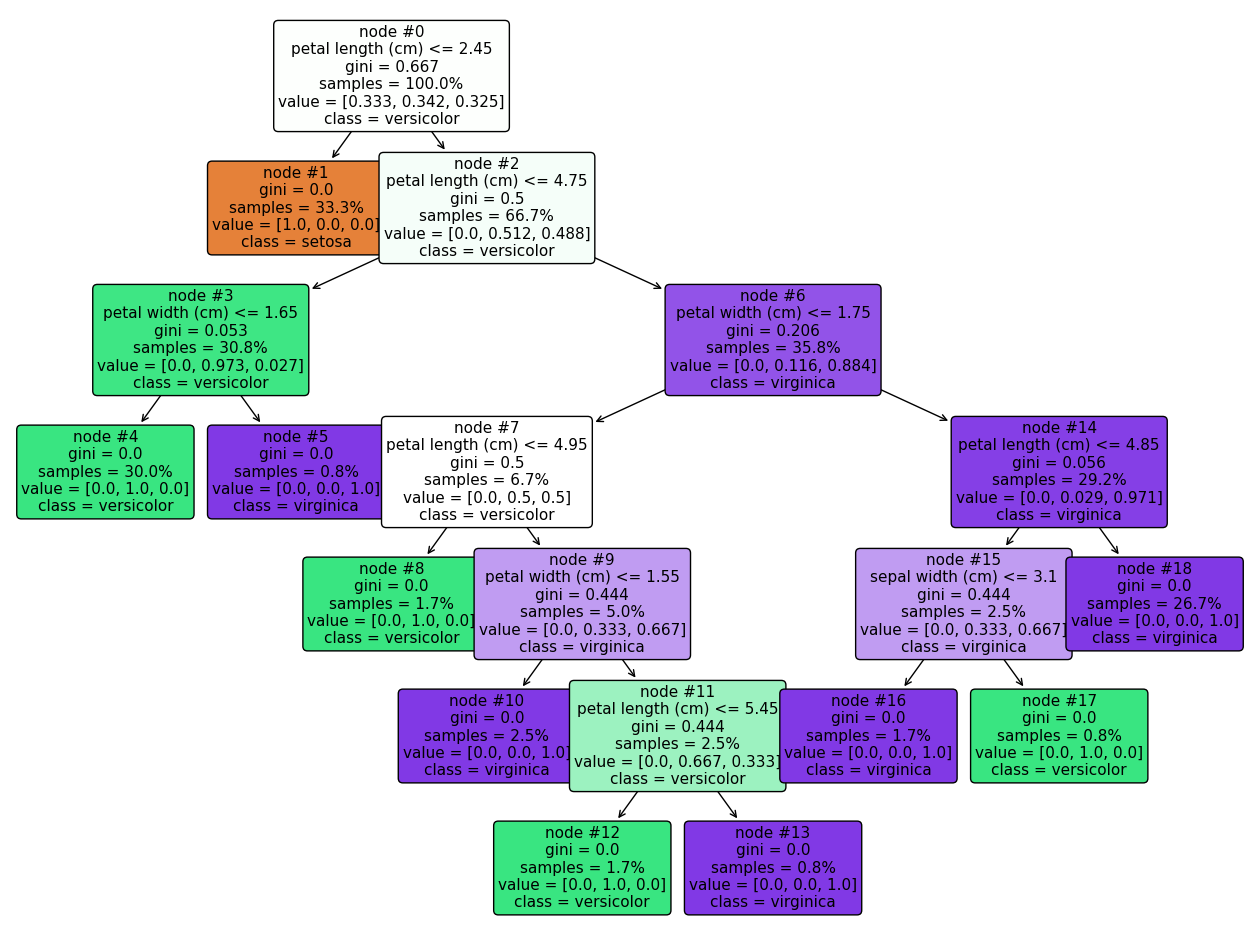

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))
_ = plot_tree(decision_tree,
              class_names=data["target_names"].tolist(),
              feature_names=data["feature_names"],
              filled=True,
              fontsize=11,
              node_ids=True,
              proportion=True,
              rounded=True,
              ax=ax)

Finally, we can evaluate the model's performance using the appropriate metrics, e.g.:

Text(0.5, 1.0, 'Confusion Matrix')

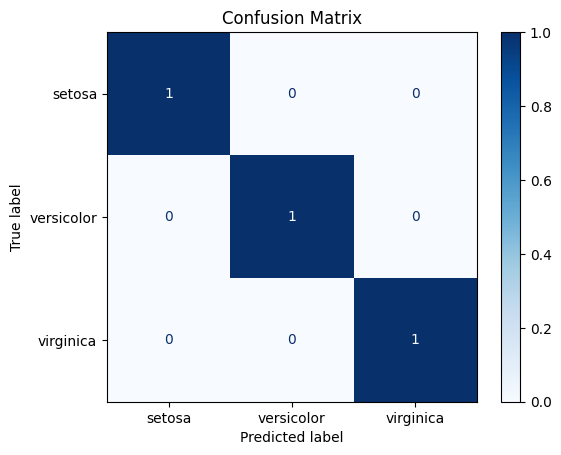

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(decision_tree,
                                             X_test,
                                             y_test,
                                             cmap=plt.cm.Blues,
                                             normalize="true",
                                             display_labels=data["target_names"])
disp.ax_.set_title("Confusion Matrix")

In [18]:
from sklearn.metrics import classification_report

y_predicted = decision_tree.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Predicting ASD Diagnosis:

Again, we will try and create a model to classify ASD diagnosis using four FreeSurfer metrics extracted over 360 brain regions. In the previous exercise we used an $\ell_2$ regularized logistic regression model (estimated using the [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) class) to select and fit a model, this time we will use the [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to do the same.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load
tsv_url = "https://raw.githubusercontent.com/neurohackademy/nh2020-curriculum/master/tu-machine-learning-yarkoni/data/abide2.tsv"
data = pd.read_csv(tsv_url, delimiter="\t")

# Clean
IGNORED_COLUMNS = ["age_resid", "sex"]
REPLACE_DICT = {"group": {1: "ASD", 2: "Control"}}
data.drop(columns=IGNORED_COLUMNS, inplace=True)
data.replace(REPLACE_DICT, inplace=True)

# Feature matrix
X = data.filter(regex="^fs").copy()  # Select columns starting with "fs"
scaler = StandardScaler()
X.loc[:, :] = scaler.fit_transform(X.loc[:, :])

# Target vector
y = data["group"] == "ASD"

# Train/test split
TRAIN_SIZE = 900

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=TRAIN_SIZE,
                                                    random_state=0)

### Random Forest

#### Model Creation

In [20]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=0)
_ = random_forest.fit(X_train, y_train)

#### Model Application

In [21]:
y_predicted = random_forest.predict(X_test)

#### Model Evaluation

##### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

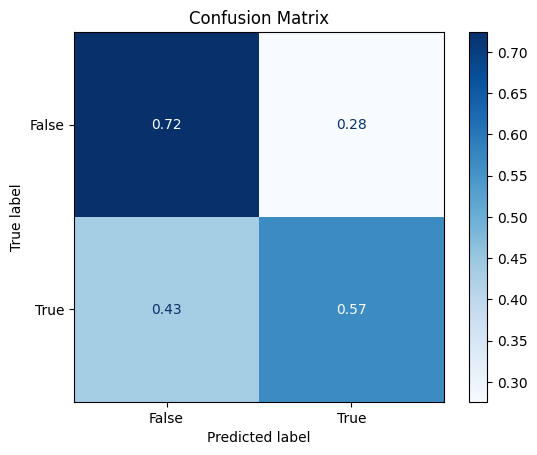

In [22]:
disp = ConfusionMatrixDisplay.from_estimator(random_forest,
                                             X_test,
                                             y_test,
                                             cmap=plt.cm.Blues,
                                             normalize="true")
disp.ax_.set_title("Confusion Matrix")

##### Classification Report

In [23]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

       False       0.68      0.72      0.70        58
        True       0.62      0.57      0.59        46

    accuracy                           0.65       104
   macro avg       0.65      0.64      0.65       104
weighted avg       0.65      0.65      0.65       104



Not too bad! We've improved our accuracy from 0.63 to 0.65.

##### Feature Importance

One of the greatest things about trees is their interpretability. `sklearn` exposes one measure ("Gini importance") as a built-in property of the fitted random forest estimator:

In [24]:
random_forest.feature_importances_

array([2.96342846e-04, 5.08910846e-05, 6.69469236e-04, ...,
       5.30759983e-04, 2.16033616e-04, 4.88856474e-04])

However, the documentation states that:

> "impurity-based feature importances can be misleading for high cardinality features (many unique values)."

In our case, having numerical features, we would be better off using the [`permutation_importance()`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) function (for more information, see [Permutation Importance vs Random Forest Feature Importance](https://scikit-learn.org/0.22/auto_examples/inspection/plot_permutation_importance.html)).

In [25]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(random_forest,
                                    X_test,
                                    y_test,
                                    random_state=0,
                                    n_jobs=8)

In [26]:
import numpy as np

MEASUREMENT_DICT = {
    "fsArea": "Surface Area",
    "fsCT": "Cortical Thinkness",
    "fsVol": "Cortical Volume",
    "fsLGI": "Local Gyrification Index"
}
HEMISPHERE_DICT = {"L": "Left", "R": "Right"}
REGION_IDS = range(1, 181)
FEATURE_INDEX = pd.MultiIndex.from_product(
    [HEMISPHERE_DICT.values(), REGION_IDS,
     MEASUREMENT_DICT.values()],
    names=["Hemisphere", "Region ID", "Measurement"])
COLUMN_NAMES = ["Identifier", "Importance"]


def parse_importance(X: pd.DataFrame, importance: np.ndarray) -> dict:
    feature_info = pd.DataFrame(index=FEATURE_INDEX, columns=COLUMN_NAMES)
    for i, column_name in enumerate(X_train.columns):
        measurement, hemisphere, identifier, _ = column_name.split("_")
        measurement = MEASUREMENT_DICT.get(measurement)
        hemisphere = HEMISPHERE_DICT.get(hemisphere)
        region_id = i % 180 + 1
        feature_info.loc[(hemisphere, region_id,
                          measurement), :] = identifier, importance[i]
    return feature_info


importance_series = parse_importance(X, importance["importances_mean"])

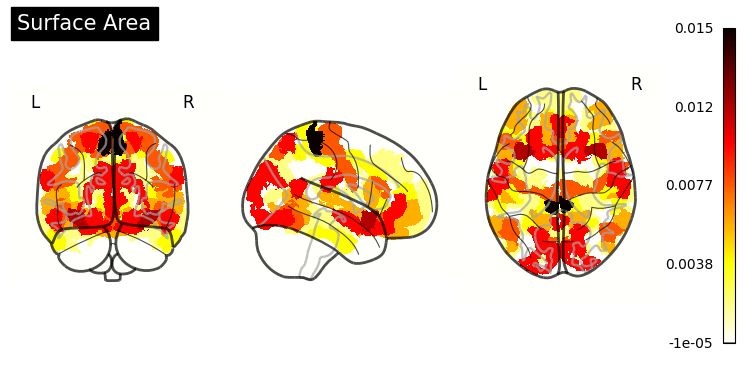

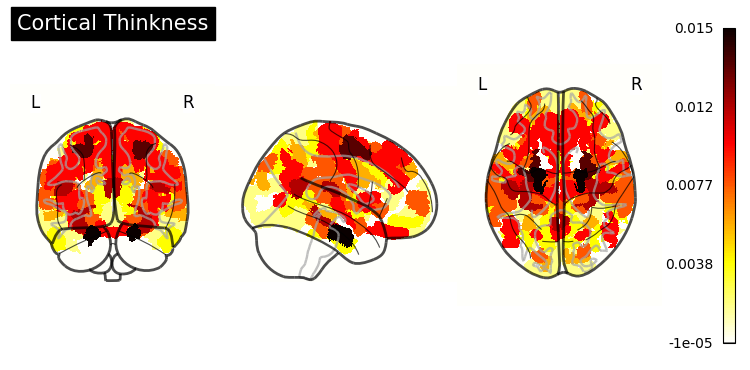

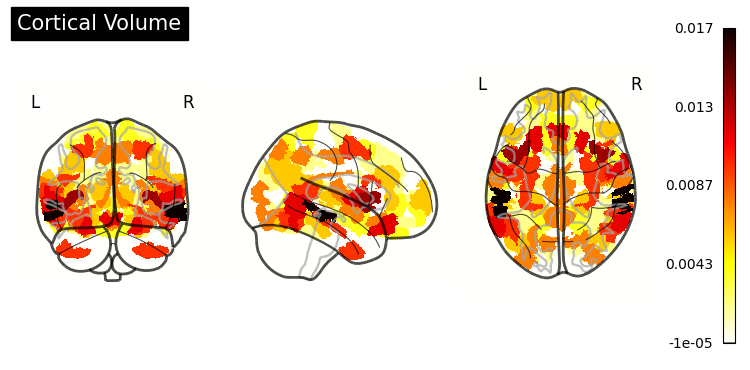

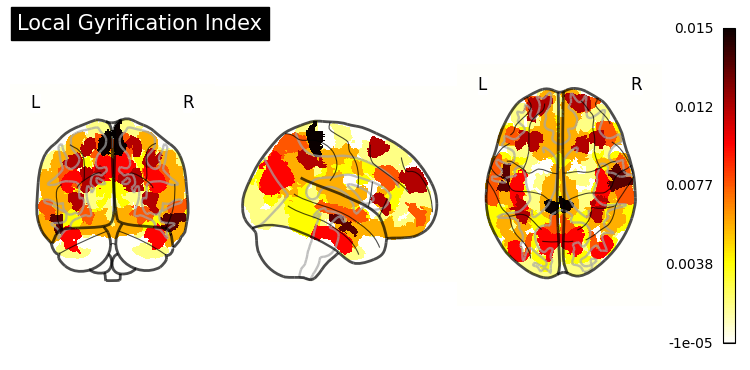

In [27]:
import nibabel as nib

from nilearn import datasets
from nilearn import plotting
from nilearn import surface
from nilearn.image import new_img_like

HCP_NIFTI_PATH = "../chapter_06/HCP-MMP1_on_MNI152_ICBM2009a_nlin.nii.gz"
HCP_IMAGE = nib.load(HCP_NIFTI_PATH)
HCP_DATA = np.round(HCP_IMAGE.get_fdata())


def plot_importance(feature_importance: pd.DataFrame,
                    measurement: str) -> None:
    """
    Plots coefficient estimation results using a "glass brain" plot.
    
    Parameters
    ----------
    coefficient_values : pd.DataFrame
        Formatted dataframe containing coefficient values indexed by
        (Hemisphere, Region ID, Measurement)
    measurement: str
        String identifier for the desired type of measurement
    """

    # Create a copy of the HCP-MMP1 atlas array
    template = HCP_DATA.copy()

    # Replace region indices in the template with their matching importance values
    for hemisphere in HEMISPHERE_DICT.values():
        # Query appropriate rows
        selection = feature_importance.xs((hemisphere, measurement),
                                          level=("Hemisphere", "Measurement"))
        # Extract an array of importance values
        values = selection["Importance"].values
        if (values > 0).any():
            # Replace region indices with values
            for region_id in REGION_IDS:
                template_id = region_id if hemisphere == "Left" else region_id + 180
                template[template == template_id] = values[region_id - 1]
        else:
            return

    # Create a `nibabel.nifti1.Nifti1Image` instance for `plot_glass_brain`
    importance_nifti = new_img_like(HCP_IMAGE, template, HCP_IMAGE.affine)

    _ = plotting.plot_glass_brain(importance_nifti,
                                  display_mode='ortho',
                                  colorbar=True,
                                  title=measurement)


for measurement in MEASUREMENT_DICT.values():
    plot_importance(importance_series, measurement)

### Gradient Boosting

#### Model Creation

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier(random_state=0)
_ = gradient_boosting.fit(X_train, y_train)

#### Model Application

In [29]:
y_predicted_gb = gradient_boosting.predict(X_test)

#### Model Evaluation

##### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

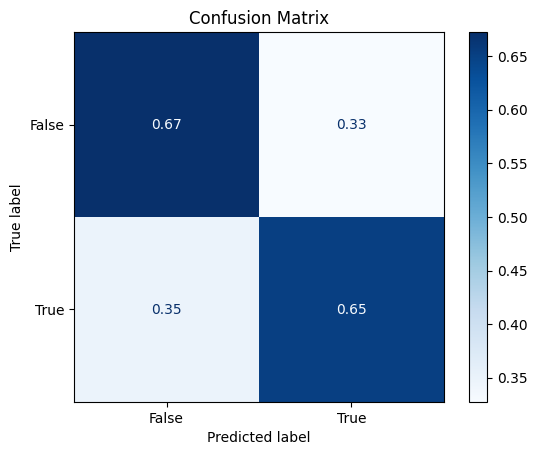

In [30]:
disp = ConfusionMatrixDisplay.from_estimator(gradient_boosting,
                                             X_test,
                                             y_test,
                                             cmap=plt.cm.Blues,
                                             normalize="true")
disp.ax_.set_title("Confusion Matrix")

##### Classification Report

In [31]:
print(classification_report(y_test, y_predicted_gb))

              precision    recall  f1-score   support

       False       0.71      0.67      0.69        58
        True       0.61      0.65      0.63        46

    accuracy                           0.66       104
   macro avg       0.66      0.66      0.66       104
weighted avg       0.67      0.66      0.66       104



We've ended up with an overall slightly better accuracy and precision.

##### Feature Importance

In [32]:
from sklearn.inspection import permutation_importance

gb_importance = permutation_importance(gradient_boosting,
                                       X_test,
                                       y_test,
                                       random_state=0,
                                       n_jobs=8)

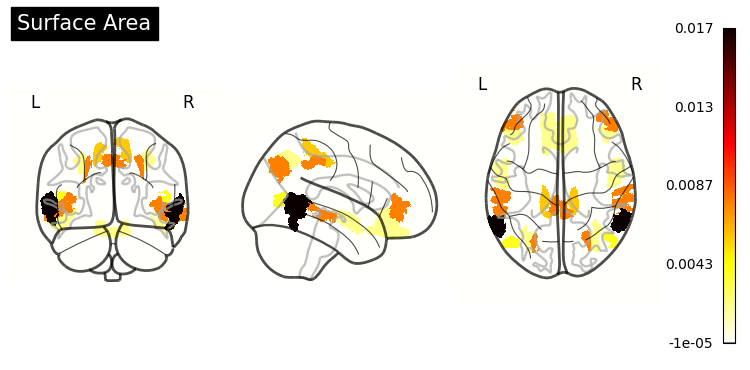

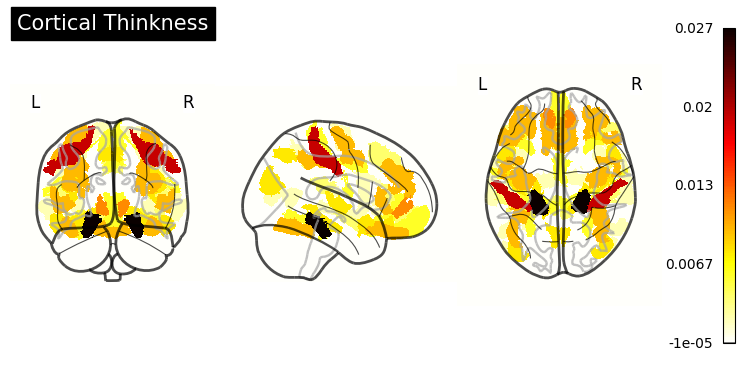

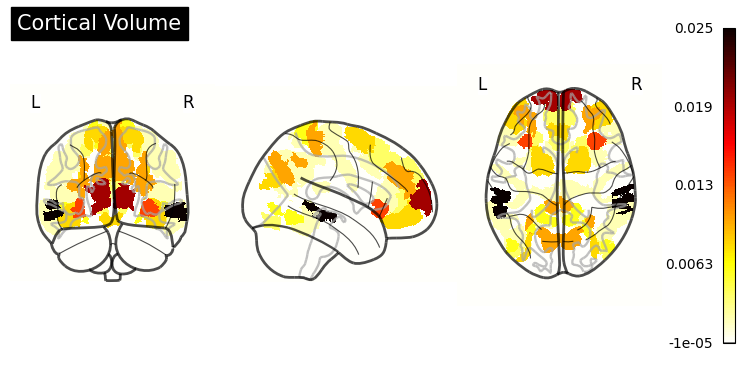

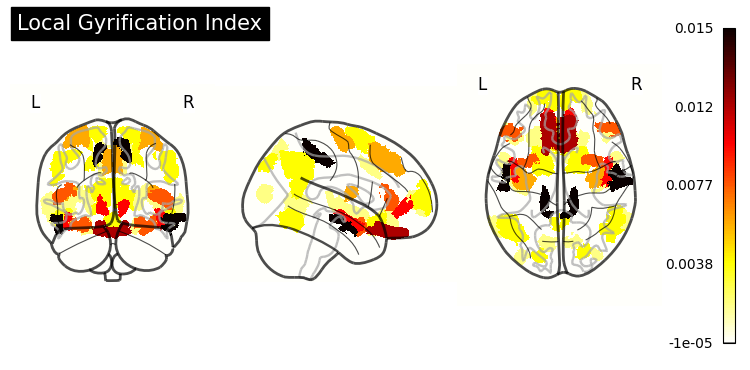

In [33]:
gb_importance_series = parse_importance(X, gb_importance["importances_mean"])
for measurement in MEASUREMENT_DICT.values():
    plot_importance(gb_importance_series, measurement)

### Hyperparameter Tuning

#### Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV

N_ESTIMATORS = range(60, 130, 10)
MAX_DEPTH = range(2, 5)
PARAM_GRID = {"n_estimators": N_ESTIMATORS, "max_depth": MAX_DEPTH}

estimator = GradientBoostingClassifier(random_state=0)
model_searcher = GridSearchCV(estimator,
                              param_grid=PARAM_GRID,
                              return_train_score=True)

##### Model Selection

In [35]:
_ = model_searcher.fit(X_train, y_train)

##### Selected Model Application

In [36]:
y_predicted_grid = model_searcher.predict(X_test)

##### Selected Model Evaluation

In [37]:
model_searcher.best_params_

{'max_depth': 3, 'n_estimators': 70}

In [38]:
model_searcher.best_score_

0.6399999999999999

###### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

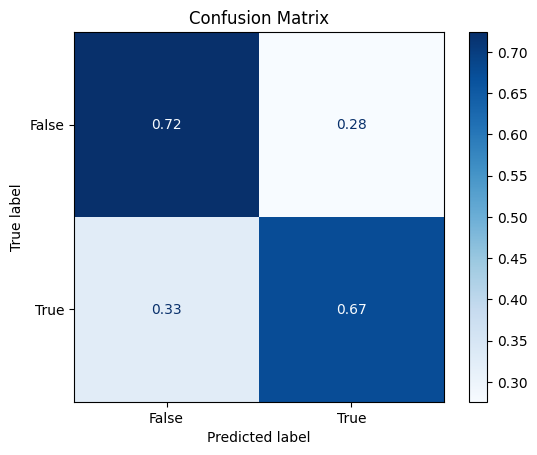

In [39]:
disp = ConfusionMatrixDisplay.from_estimator(model_searcher,
                                             X_test,
                                             y_test,
                                             cmap=plt.cm.Blues,
                                             normalize="true")
disp.ax_.set_title("Confusion Matrix")

###### Classification Report

In [40]:
print(classification_report(y_test, y_predicted_grid))

              precision    recall  f1-score   support

       False       0.74      0.72      0.73        58
        True       0.66      0.67      0.67        46

    accuracy                           0.70       104
   macro avg       0.70      0.70      0.70       104
weighted avg       0.70      0.70      0.70       104



###### Model Selection

In [41]:
COLORS = "red", "green", "blue"
PARAM_COLUMNS = [
    "param_max_depth", "param_n_estimators", "mean_train_score",
    "mean_test_score", "std_train_score", "std_test_score"
]
PARAM_COLUMN_NAMES = [
    "Max Depth", "Number of Estimators", "Mean Train Score", "Mean Test Score",
    "Train Score STD", "Test Score STD"
]


def plot_search_results(cv_results: dict):
    data = pd.DataFrame(cv_results)[PARAM_COLUMNS].copy()
    data.columns = PARAM_COLUMN_NAMES
    param_fig, param_ax = plt.subplots(figsize=(10, 5))
    param_ax.set_title(
        "GridSearchCV Test-set Accuracy by Number of Estimators and Max. Depth"
    )

    for i, (key, grp) in enumerate(data.groupby(["Max Depth"])):
        grp.plot(kind="line",
                 x="Number of Estimators",
                 y="Mean Test Score",
                 color=COLORS[i],
                 label=str(key),
                 ax=param_ax)
        score_mean = grp["Mean Test Score"]
        score_std = grp["Test Score STD"]
        score_lower_limit = score_mean - score_std
        score_upper_limit = score_mean + score_std
        param_ax.fill_between(N_ESTIMATORS,
                              score_lower_limit,
                              score_upper_limit,
                              color=COLORS[i],
                              alpha=0.1)
    param_ax.set_ylabel("Accuracy")
    param_ax.scatter(model_searcher.best_params_["n_estimators"],
                     model_searcher.best_score_,
                     marker="*",
                     color="black",
                     s=150,
                     label="Selected Model")
    _ = param_ax.legend()

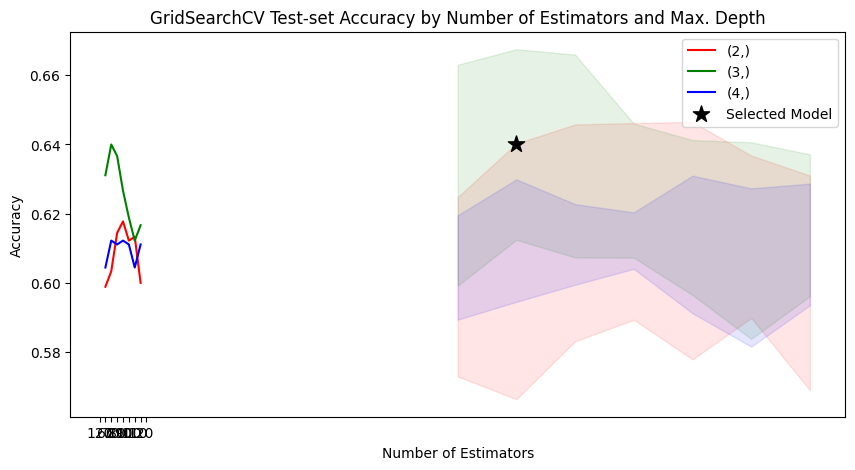

In [42]:
plot_search_results(model_searcher.cv_results_)

What would happen if we changed `cv` from it's default value (5) to 10? Would `GridSearchCV` select the same model?

In [43]:
model_searcher_2 = GridSearchCV(estimator,
                                param_grid=PARAM_GRID,
                                return_train_score=True,
                                cv=10)

##### Model Selection

In [44]:
_ = model_searcher_2.fit(X_train, y_train)

##### Selected Model Application

In [ ]:
y_predicted_grid_2 = model_searcher_2.predict(X_test)

: 

##### Selected Model Evaluation

In [ ]:
model_searcher_2.best_params_

: 

In [ ]:
model_searcher_2.best_score_

: 

###### Confusion Matrix

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model_searcher_2,
                                             X_test,
                                             y_test,
                                             cmap=plt.cm.Blues,
                                             normalize="true")
disp.ax_.set_title("Confusion Matrix")

: 

###### Classification Report

In [ ]:
print(classification_report(y_test, y_predicted_grid_2))

: 

##### Feature Importance

In [ ]:
grid_importance = permutation_importance(model_searcher_2,
                                         X_test,
                                         y_test,
                                         random_state=0,
                                         n_jobs=8)

NameError: name 'model_searcher_2' is not defined

In [ ]:
grid_importance_series = parse_importance(X,
                                          grid_importance["importances_mean"])
for measurement in MEASUREMENT_DICT.values():
    plot_importance(grid_importance_series, measurement)

: 